![RippleLabs](https://wiki.ripple.com/images/3/32/Logo_M.png "Ripple")

<br />
<br />
[Gilles Pirio](mailto:gilles.xrp@gmail.com) @ Ripple Research & Data Team

August 25, 2015

# Visualizing Order Book in Time

Analysis of the dynamic of a market and order books, for investigative or trading purposes, require a specific set of tools. In particular, given the relative anonymity of accounts and trading orders on the Ripple Consensus Ledger (RCL), it may be necessary to cross-reference accounts with payments and orders to understand the different actions and strategies at play on the different Ripple order books.

Several research team are investigating that topic and some great tools have been developed and presented recently. Study [1] introduced a new pipeline for 2D/3D display of order books that inspired the work presented here. These type of tools are however usually complex project built around a high-speed processing backends. They usually require investment in research and engineering.

We use a very simple, Pyhton-based approach to display order books in time on the Ripple Consensus Ledger. 

Let's start by importing useful modules from [matplotlib](http://matplotlib.org/) (the plotting package) and [pyripple](https://github.com/gip/pyripple). We then create a feed object to get data from Ripple. 

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
from pyripple.feed import syncfeed
from pyripple.protocol import orderbook
feed = syncfeed.SyncFeed()

We want to look at the XRP / USD@Bitstamp order book. [Bitstamp](https://www.bitstamp.net/) is a major gateway on Ripple, issuer of GBP, USD and EUR.

Please refer to [Visualizing order books on Ripple](http://nbviewer.ipython.org/github/gip/techtrading/blob/master/ripple/OrderbooksRipple.ipynb) for more information about pulling order books.

In [18]:
# Bitstamp issuer address
Bitstamp = 'rvYAfWj5gh67oV6fW32ZzP3Aw4Eubs59B'
# Getting USD@Bitstamp / XRP order book
USDXRP_Bitstamp = feed.getOrderbook(('USD', Bitstamp), ('XRP', None))
# Show some information
USDXRP_Bitstamp.showInfo()

Orderbook USDXRP in ledger 15462528
  Close date: None
  Currency: USD@rvYAfWj5gh67oV6fW32ZzP3Aw4Eubs59B
  Counter currency: XRP
  Spread: 0.623236 (0.461810 %)
  Best ask/bid: 134.955032 / 134.331796
  Through:  []


We want to look into the recent past to understand the root cause of the market volatility. The current Ripple ledger being `15462528`, we first define an array with the ledger indexes we are interested in. Ideally we would pull the order books for all the latest 2000 ledgers (corresponding to the previous ~2 hours). Since we pull the ledgers sequentially, this would be slow. For speed, we therefore will pull 1 order book out of 5.

In [33]:
import numpy as np
current_ledger = 15462528
ledgers = np.arange(current_ledger-2000, current_ledger, 5)

Now we are going to pull the order books for the ledgers. As mentioned before, **this can take some time**.

In [34]:
order_books = map(lambda ldg: feed.getOrderbook(('USD', Bitstamp), ('XRP', None), ledger= ldg), ledgers)

We now plot order books in time using the `plotTimeResolvedBook()` method. *(Note that the next version of [pyripple](https://github.com/gip/pyripple) will include some refactoring and the method name and location may change).*

(15460528, 15462528)

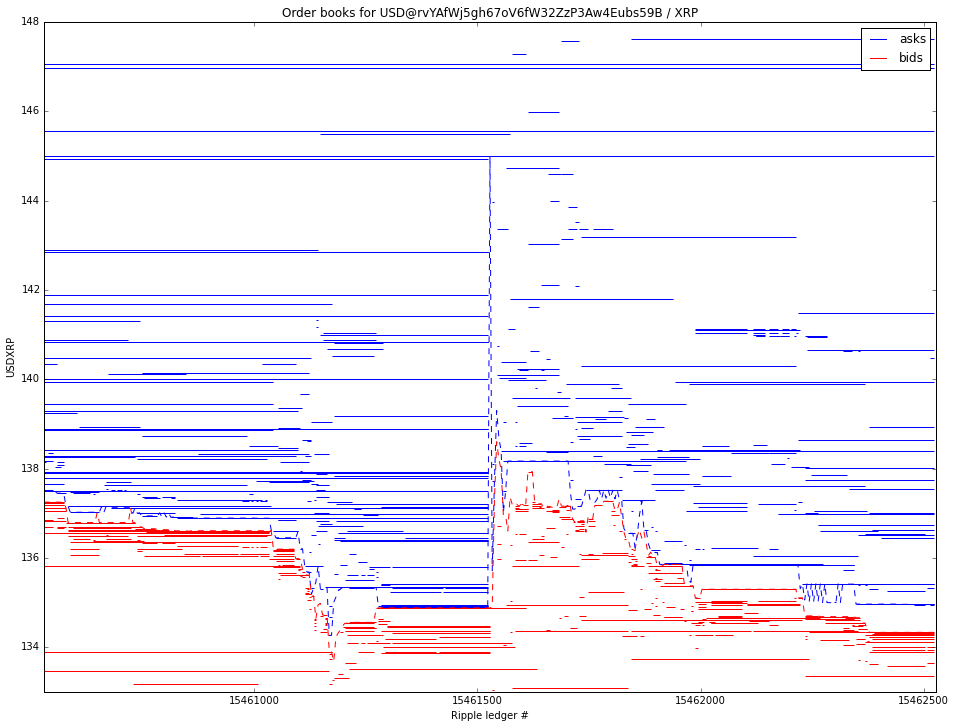

In [36]:
orderbook.Orderbook.plotTimeResolvedBook(order_books)
plt.gca().set_ylim((133, 148))
plt.gca().set_xlim((current_ledger-2000, current_ledger))

The above plot show the dynamic of the different bid/ask orders on the given order book. The orders disappear when they are consumed (by another order of a payment) or where they are canceled. The graph above basically shows that something happened around ledger `#15461500`. Let's focus on this area of interest and plot all the order books around this time. 

In [42]:
ledgers2 = np.arange(15461500, 15461500+100, 1)

In [43]:
order_books2 = map(lambda ldg: feed.getOrderbook(('USD', Bitstamp), ('XRP', None), ledger= ldg), ledgers2)

(15461500, 15461599)

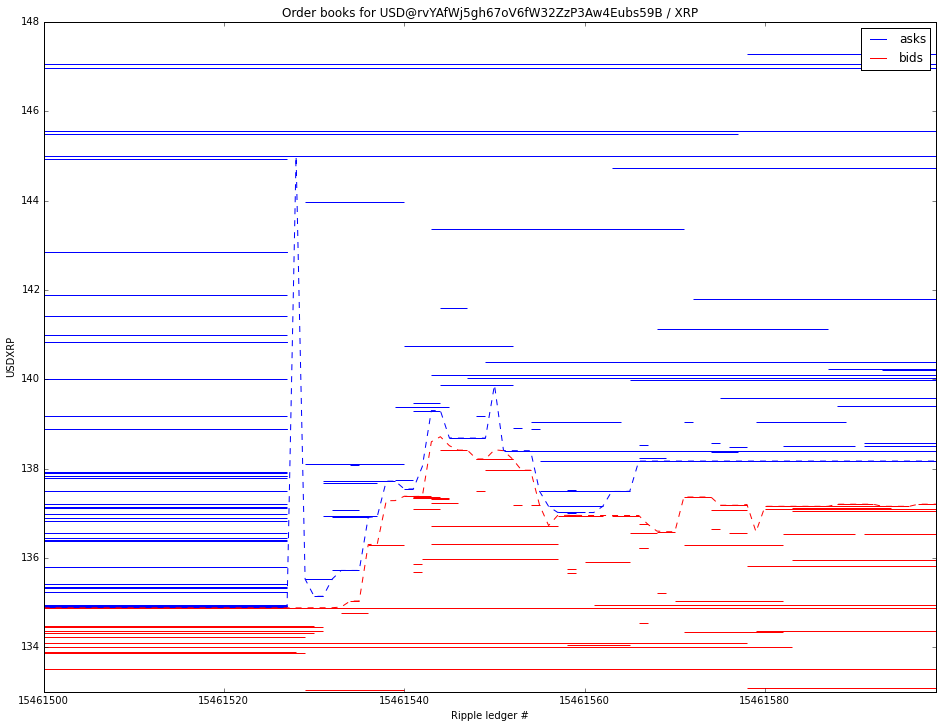

In [44]:
orderbook.Orderbook.plotTimeResolvedBook(order_books2)
plt.gca().set_ylim((133, 148))
plt.gca().set_xlim((ledgers2.min(), ledgers2.max()))

We now have a clearer view of what is happening. I large USD buy order consumed some existing asks, making the USDXRP best ask jump from ~135 to ~145. That triggered some order cancelation (this was probably automated), which in turn led to the rate to go up by around 2%. 

Data obtained independently confirmed that the correction was mostly driven by automated traders following a repeatable and consistent pattern.

## Conclusion

A very simple approach to analyse the dynamic evolution of order books on Ripple was presented.

* While this approach is simple, it is quite slow. The next version of [pyripple](https://github.com/gip/pyripple) will include caching and paralelization to fetch the data much faster.

* We would want to show the size of each order, as done in reference [1].

* A key feature to be developed is the ability for the user to identify whom an order belongs to. The feasability of a tool built on [d3js](http://d3js.org/) will be explored.

* We also want to know the reason for an order disappearing - it may be because the order was canceled or because the order was consumed. This could easily be shown on the graph once the data is available.

* Add indication of the exchange volume and real dates (not Ripple ledger index) should be added.

* Finally, the use of this feature in production would definitely require some fast preprocessing or at least a fast storage layer.

Please contact [Gilles Pirio](mailto:gilles.xrp@gmail.com) for any comment or feedback.

## References

[1] [OSQF Order Book Visualization](http://osqf.tpq.io/osqf_ffm/OSQF_Order_Book_Visualization.pdf) A recent study on how to better plot and 'play in time' order books from two engineers at Deutsche Börse. Similar with 3D views. A backend was developed to preprocess the data.